In [1]:
!conda install -c conda-forge catboost -y

Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - catboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.38.0             |       h1d18e73_1         359 KB  conda-forge
    ca-certificates-2024.7.4   |       h8857fd0_0         151 KB  conda-forge
    cairo-1.16.0               |       h3ce6f7e_5        1013 KB
    catboost-1.2.5             |  py312hb401068_0        18.5 MB  conda-forge
    certifi-2024.7.4           |     pyhd8ed1ab_0         156 KB  conda-forge
    conda-24.5.0               |  py312hb401068_0         1.2 MB  conda-forge
    font-ttf-dejavu-sans-mono-2.37|       hab24e00_0         388 KB  conda-forge
    font-ttf-inconsolata-3.000 |       h77eed37_0          94 KB  conda-forge
    font-ttf-source-code-pro-2.038|       h77eed37_0       

In [2]:
import catboost
print(catboost.__version__)

1.2.5


Best parameters found: {'bagging_temperature': 0.1, 'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 10, 'learning_rate': 0.01, 'random_strength': 0.7, 'subsample': 0.6}
Best cross-validation MAE: 0.0962
Mean Absolute Error (MAE): 0.0941
Mean Squared Error (MSE): 0.0165
R-squared (R2): 0.8547
Root Mean Squared Error (RMSE): 0.1285
Mean Actual Value: 7.1054
Mean Absolute Percentage Error (MAPE): 1.34%
最適なCatBoostモデルが保存されました: /Users/hayakawakazue/Downloads/second_apt_2024_summer/model/catboost_model_0806_2.joblib


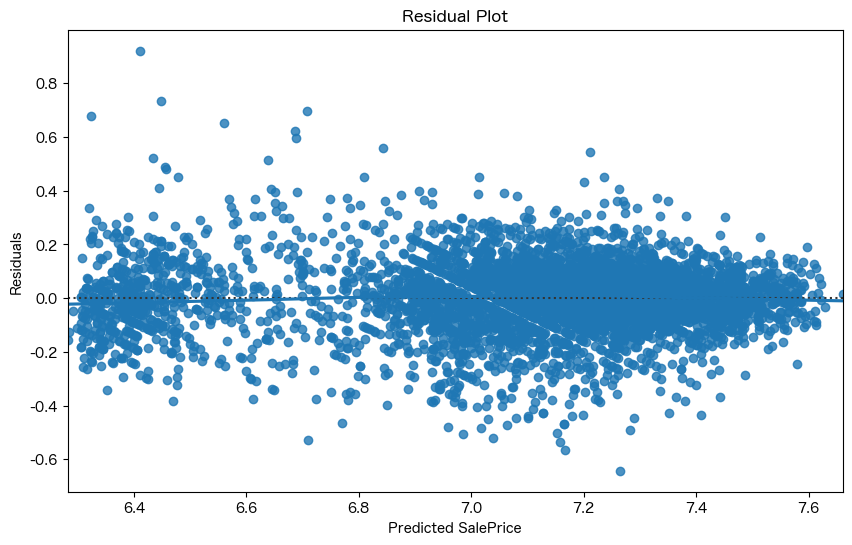

In [1]:
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
import joblib

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# 保存されたデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_scaled_features.csv'
data = pd.read_csv(data_path)

# 特徴量の選択
selected_features = [
    '長期価格トレンド', 'エリア人気度スコア', '市区町村コード', 
    '取引時点', '駅距離_面積比', '面積/築年数比', '建築年スコア', 
    '築年数', '面積×容積率', '建築年×建ぺい率'
]

# 特徴量の存在確認
missing_features = [feature for feature in selected_features if feature not in data.columns]
if missing_features:
    raise ValueError(f"Missing features in the data: {missing_features}")

# 特徴量と目的変数を分ける
X = data[selected_features]
y = data['取引価格（総額）_log']

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

# CatBoostRegressorのインスタンスを作成
cbr_model = CatBoostRegressor(random_state=52, verbose=0)

# ハイパーパラメータの設定
param_grid = {
    'iterations': [700, 1000],  # Increased iterations
    'depth': [3, 4],  # Reduced depth
    'learning_rate': [0.005, 0.01],  # Reduced learning rates
    'l2_leaf_reg': [10, 15, 20],  # Stronger regularization
    'random_strength': [0.7, 1.0],  # Increased randomness
    'bagging_temperature': [0.1, 0.3],
    'subsample': [0.5, 0.6]
}

# クロスバリデーションを増やす
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Increase number of folds

# グリッドサーチ
grid_search = GridSearchCV(
    estimator=cbr_model, 
    param_grid=param_grid, 
    cv=kf,  # Use the KFold instance
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# 最適なモデル
cbr_best = grid_search.best_estimator_

# 予測の実行
y_pred = cbr_best.predict(X_test)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation MAE: {-grid_search.best_score_:.4f}")

# 評価指標の計算
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# 結果の表示
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 実際の値の平均を計算
mean_actual_value = np.mean(y_test)
print(f"Mean Actual Value: {mean_actual_value:.4f}")

# 誤差のパーセンテージを計算
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# モデルの保存
model_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/model/catboost_model_0806_2.joblib'
joblib.dump(cbr_best, model_path)
print(f"最適なCatBoostモデルが保存されました: {model_path}")

# 残差プロットの作成
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=(y_test - y_pred), lowess=True)
plt.title('Residual Plot')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')
plt.show()            


## 重要な特徴量を可視化する

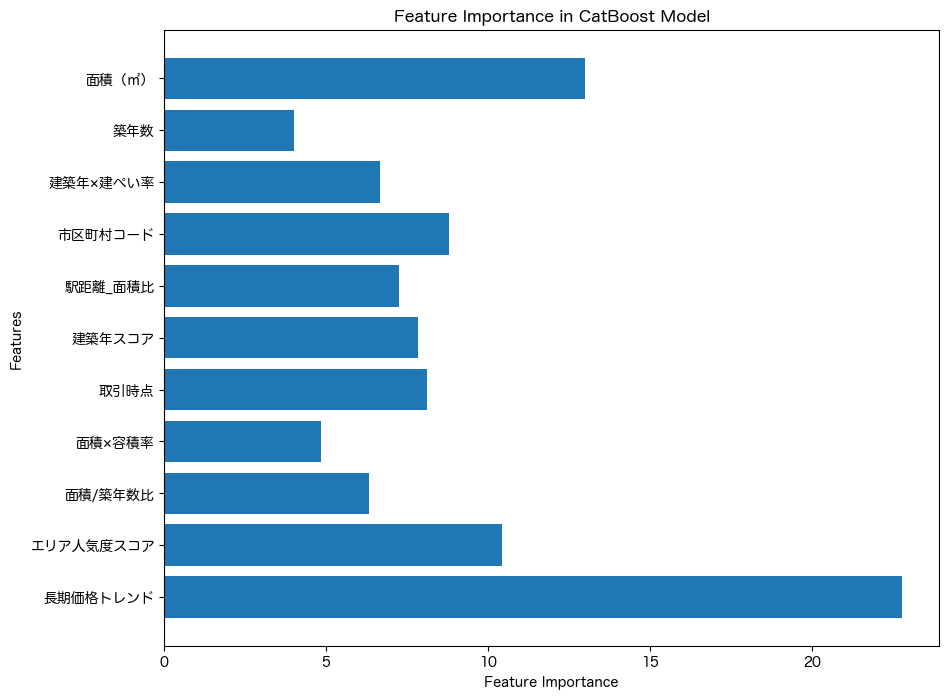

In [2]:
import matplotlib.pyplot as plt
from catboost import Pool

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# 特徴量の重要度を取得
feature_importances = cbr_best.get_feature_importance(Pool(X_train, y_train))
feature_names = X.columns

# 可視化
plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in CatBoost Model")
plt.show()


## 予測誤差の分布を確認する

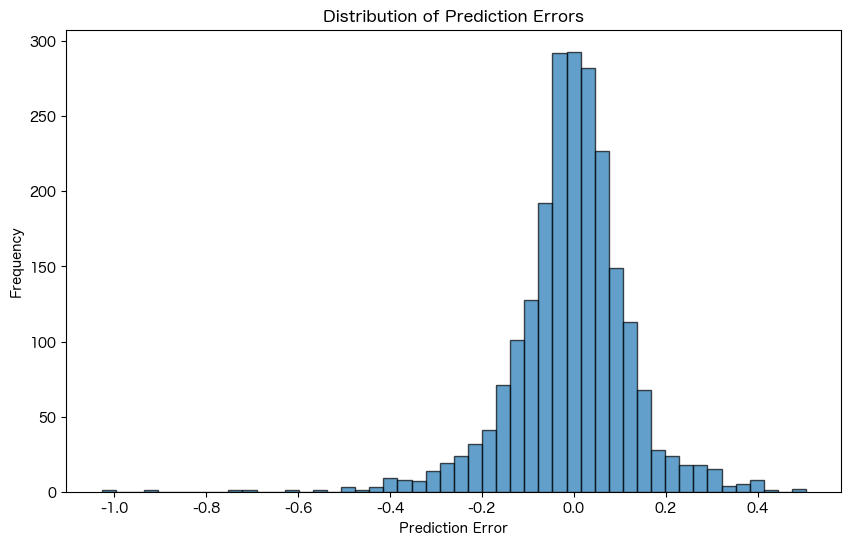

In [3]:
import matplotlib.pyplot as plt

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# 予測誤差の計算
errors = y_test - y_pred

# 予測誤差のヒストグラム
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


## 特定の特徴量に対する予測誤差を分析する

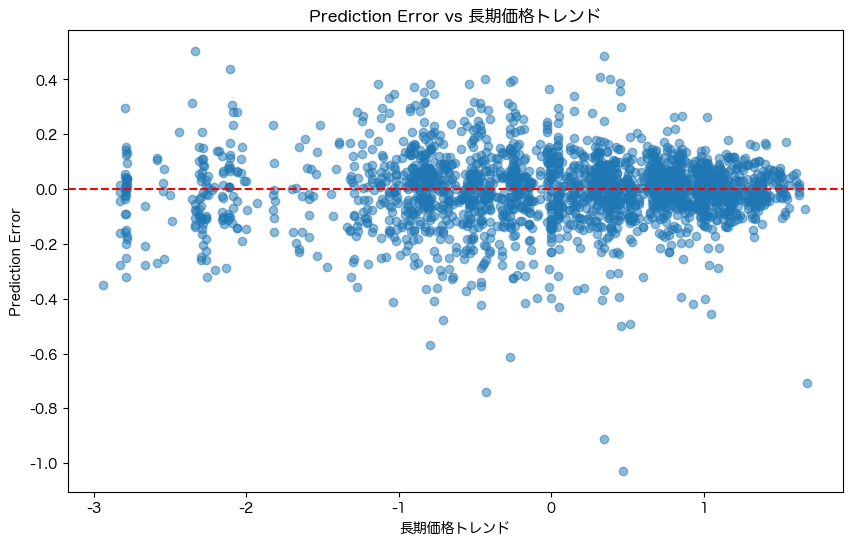

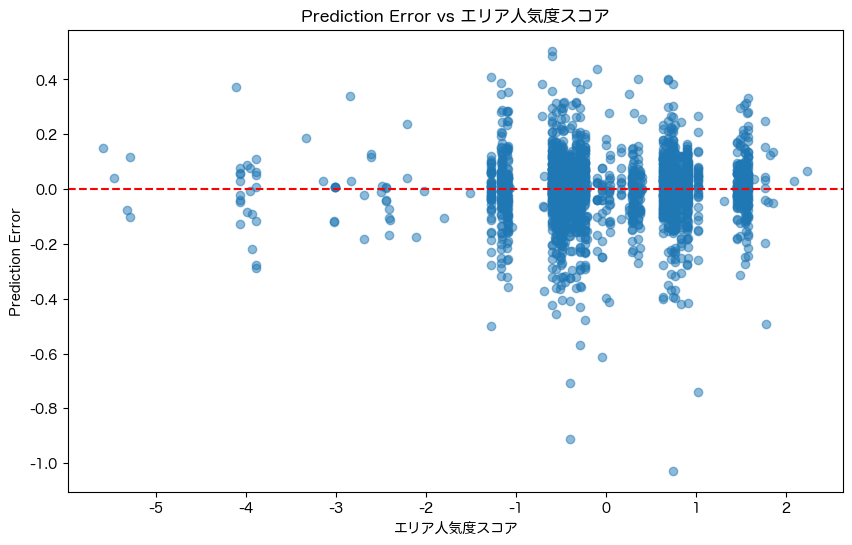

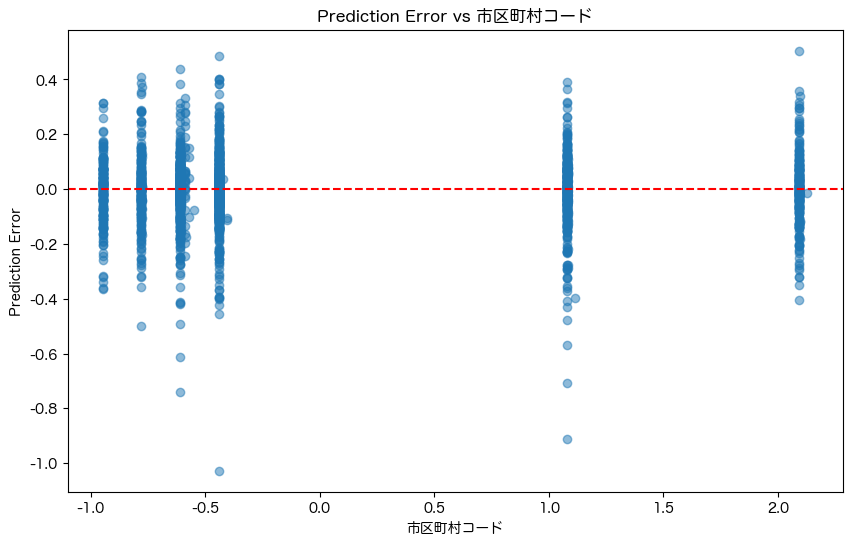

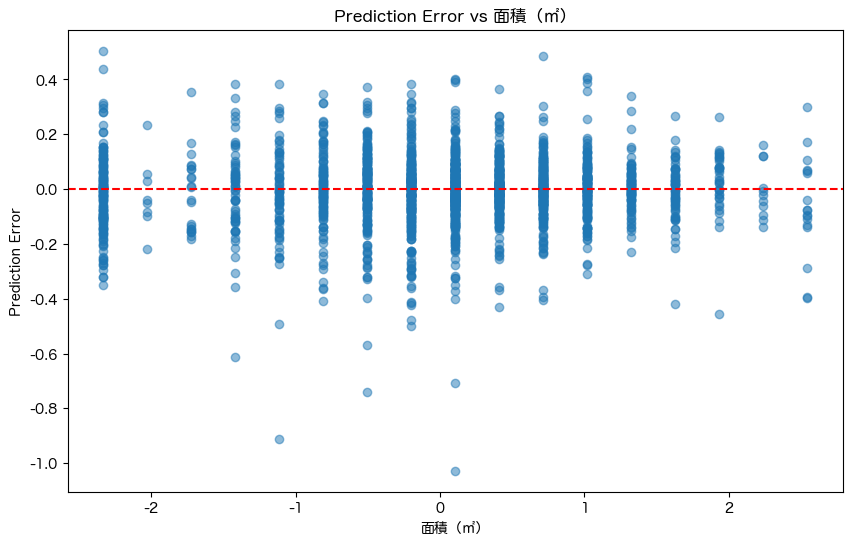

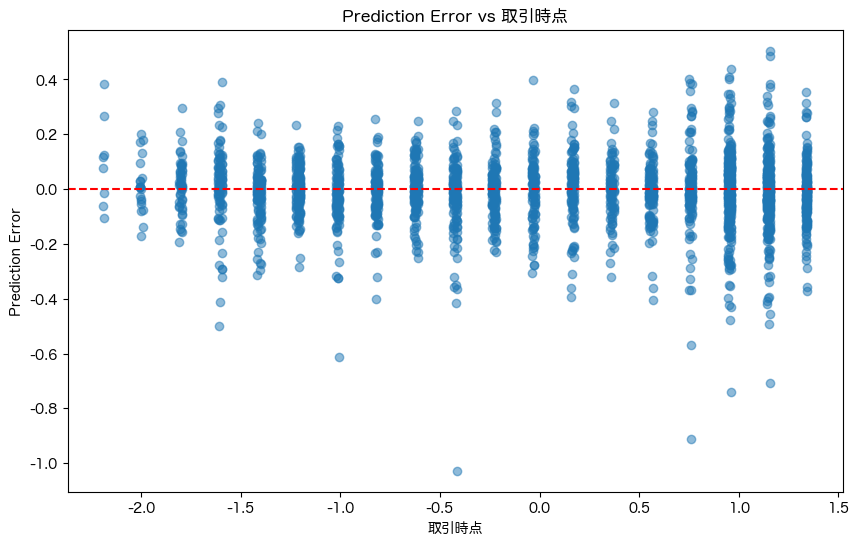

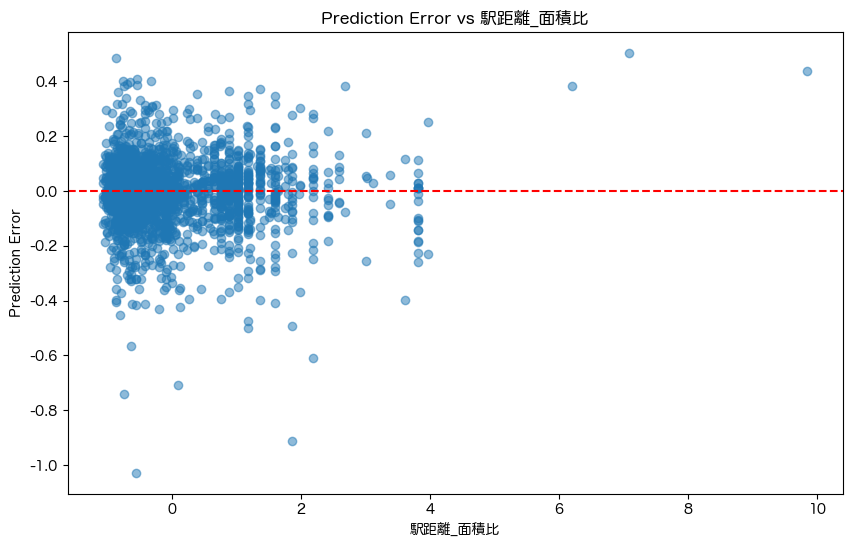

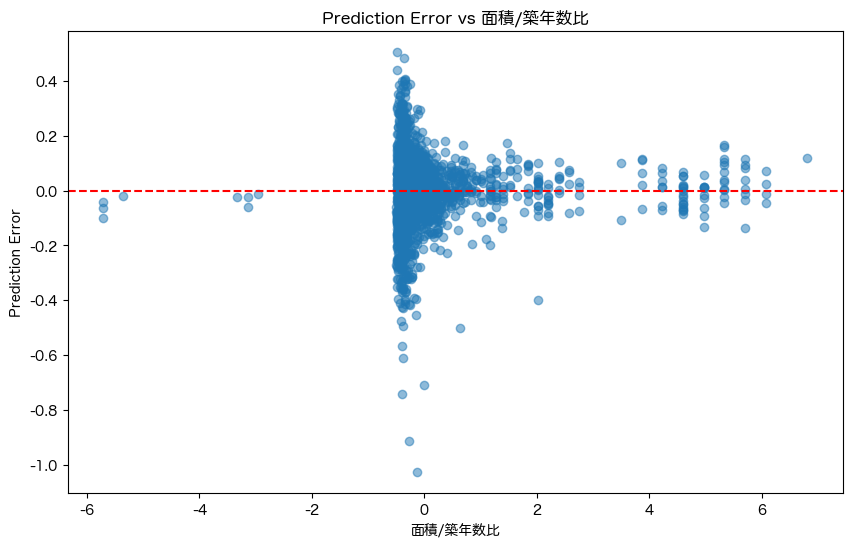

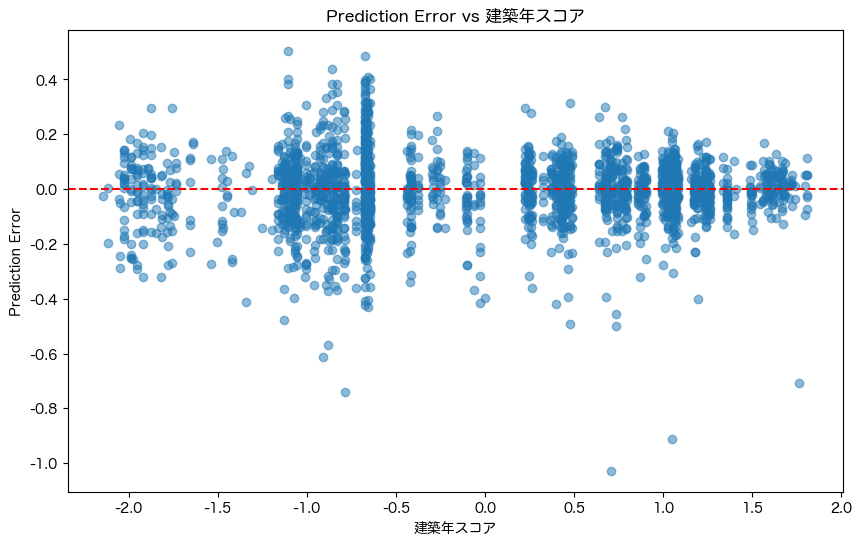

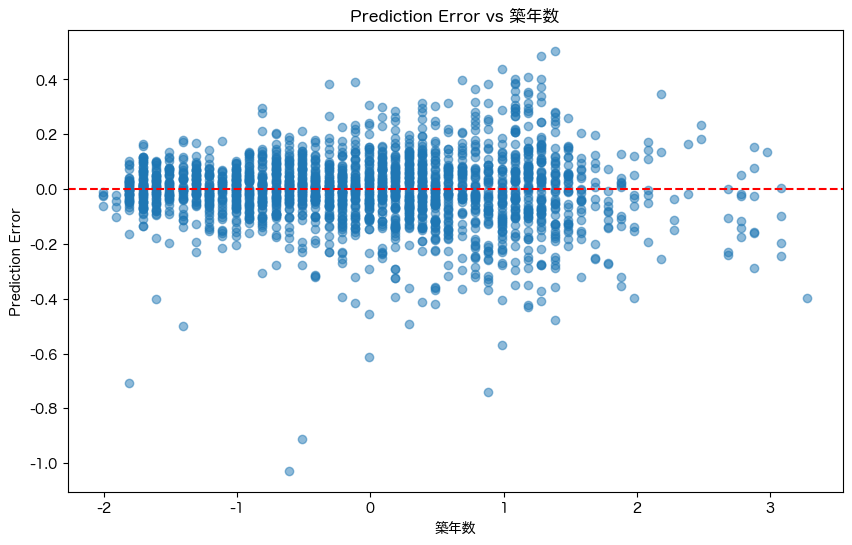

KeyError: '建築年'

<Figure size 1000x600 with 0 Axes>

In [4]:
# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# 重要度の高い特徴量に対する予測誤差のプロット
important_features_top = [
    '長期価格トレンド', 'エリア人気度スコア', '市区町村コード', '面積（㎡）',
    '取引時点', '駅距離_面積比', '面積/築年数比', '建築年スコア',
    '築年数', '建築年', '建築年×建ぺい率' 
]

for feature in important_features_top:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test[feature], errors, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Prediction Error")
    plt.title(f"Prediction Error vs {feature}")
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()


## モデルの残差プロットを確認する

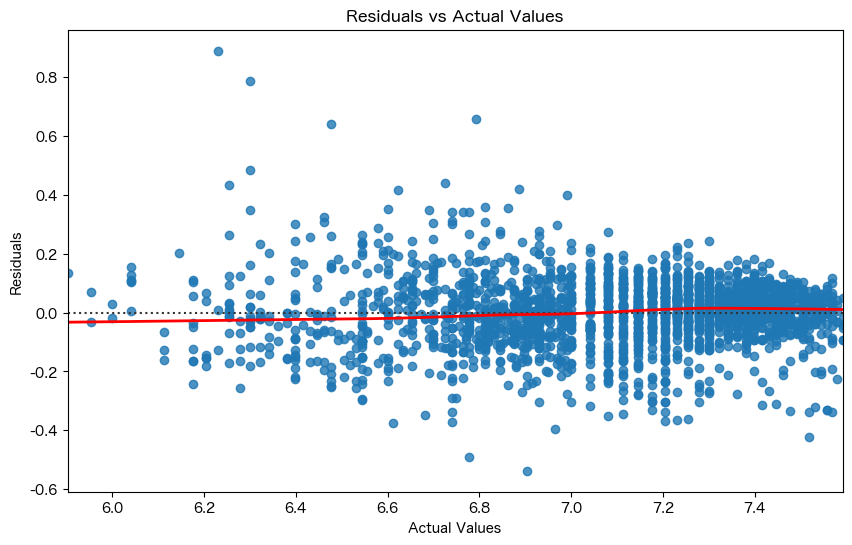

In [5]:
import seaborn as sns

# 残差プロット
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=y_pred, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Actual Values")
plt.show()


## 過学習の有無を確認する

Training Mean Absolute Error (MAE): 0.0944
Training Mean Squared Error (MSE): 0.0163
Training R-squared (R2): 0.8525
Training Root Mean Squared Error (RMSE): 0.1278


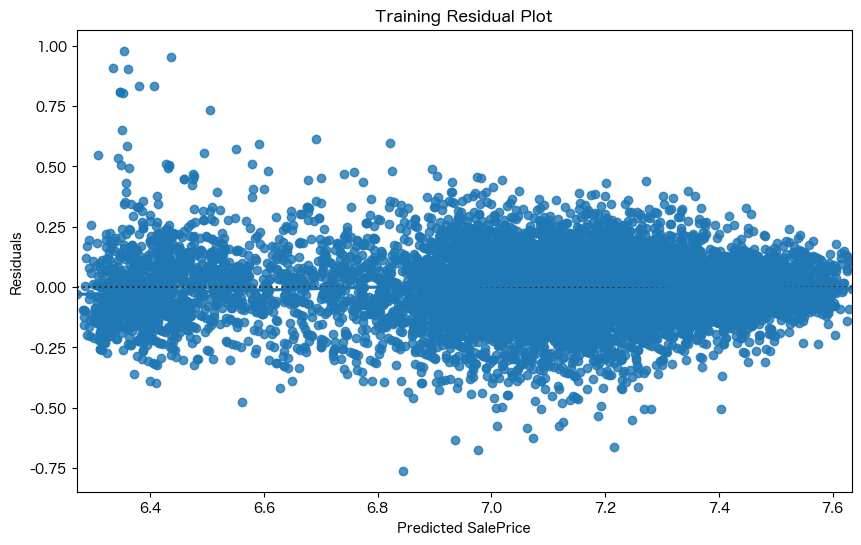

In [2]:
import seaborn as sns

# トレーニングデータを使った予測
y_train_pred = cbr_best.predict(X_train)

# トレーニングデータの評価指標の計算
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# 結果の表示
print(f"Training Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"Training Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Training R-squared (R2): {train_r2:.4f}")
print(f"Training Root Mean Squared Error (RMSE): {train_rmse:.4f}")

# 残差プロットの作成（トレーニングデータ）
plt.figure(figsize=(10, 6))
sns.residplot(x=y_train_pred, y=(y_train - y_train_pred), lowess=True)
plt.title('Training Residual Plot')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')
plt.show()

## クロスバリエーション

In [3]:
from sklearn.model_selection import cross_val_score

# クロスバリデーションの実施
cv_scores = cross_val_score(cbr_best, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# 平均スコアの計算
mean_cv_score = -cv_scores.mean()

print(f"Cross-validation Mean Absolute Error (MAE): {mean_cv_score:.4f}")

Cross-validation Mean Absolute Error (MAE): 0.0962


## モデルを再トレーニングする

In [10]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib

# 新しいデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/house_price/train/scaled_data_with_log_features.csv'
df = pd.read_csv(data_path)

# 新しい特徴量を含めた選択
important_features_with_log = [
    'log_OverallQual_Capped', 'log_OverallQualityInteraction',  
    'FunctionalSpace', 'GarageQuality', 'capped_log_GrLivArea', 
    'BasementQualityInteraction', 'log_TotalBsmtSF_Capped', 
    'LotArea', 'GarageInteraction_Capped', 'BsmtFinSF1_Capped', 'TotalBath_Capped', 
    'OverallHomeQuality', 'GarageCars_Capped', 'BsmtExposureQual', 
    'ExterQual_Cond', 'OverallCond', 'HouseAge', 'OutdoorSpaceQuality'
]

# データセットの作成
X = df[important_features_with_log]
y = df['SalePrice']

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

# CatBoostRegressorのインスタンスを作成
cbr = CatBoostRegressor(random_state=21, verbose=0)

# ハイパーパラメータの設定
param_grid = {
    'iterations': [500, 1000, 1500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# グリッドサーチ
grid_search = GridSearchCV(estimator=cbr, param_grid=param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 最適なモデル
cbr_best = grid_search.best_estimator_

# 予測の実行
y_pred = cbr_best.predict(X_test)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation MAE: {-grid_search.best_score_:.4f}")

# 評価指標の計算
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# 結果の表示
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# モデルの保存
model_path = '/Users/hayakawakazue/Downloads/house_price/model/catboost_0723_1.joblib'
joblib.dump(cbr_best, model_path)

print(f"最適なCatBoostモデルが保存されました: {model_path}")

# 実際の値の平均を計算
mean_actual_value = np.mean(y_test)
print(f"Mean Actual Value: {mean_actual_value:.4f}")

# 誤差のパーセンテージを計算
error_percentage = (mae / mean_actual_value) * 100
print(f"Mean Absolute Percentage Error (MAPE): {error_percentage:.2f}%")


Best parameters found: {'depth': 6, 'iterations': 1500, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Best cross-validation MAE: 15596.3452
Mean Absolute Error (MAE): 16732.0731
Mean Squared Error (MSE): 1455493792.3508
R-squared (R2): 0.7664
Root Mean Squared Error (RMSE): 38150.9344
最適なCatBoostモデルが保存されました: /Users/hayakawakazue/Downloads/house_price/model/catboost_0723_1.joblib
Mean Actual Value: 176202.5799
Mean Absolute Percentage Error (MAPE): 9.50%
